Reg. no: 20BAI1055

Name: Rakesh Kumar K S

Lab assignment 6

Our goal is to draw bounding boxes and predict output classes on those bounding boxes using RCNN

I decided to do a "Cat" detector

(Side note: Sorry for the late submission, I got a lot of errors while doing this myself with some other dataset so got help from my friends to resolve the errors after giving up on it for a bit and managed to finish it now)

## Downloading the dataset to colab's storage

In [2]:
!gdown --fuzzy https://drive.google.com/file/d/1AbxtyASLURWU4jbvH0SM7PGfNHcxccrH/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1AbxtyASLURWU4jbvH0SM7PGfNHcxccrH
To: /content/dog_cat.zip
100% 1.10G/1.10G [00:13<00:00, 81.9MB/s]


In [3]:
!unzip dog_cat.zip

Streaming output truncated to the last 5000 lines.
  inflating: annotations/Cats_Test3132.xml  
  inflating: annotations/Cats_Test3133.xml  
  inflating: annotations/Cats_Test3134.xml  
  inflating: annotations/Cats_Test3135.xml  
  inflating: annotations/Cats_Test3136.xml  
  inflating: annotations/Cats_Test3137.xml  
  inflating: annotations/Cats_Test3138.xml  
  inflating: annotations/Cats_Test3139.xml  
  inflating: annotations/Cats_Test314.xml  
  inflating: annotations/Cats_Test3140.xml  
  inflating: annotations/Cats_Test3141.xml  
  inflating: annotations/Cats_Test3142.xml  
  inflating: annotations/Cats_Test3143.xml  
  inflating: annotations/Cats_Test3144.xml  
  inflating: annotations/Cats_Test3145.xml  
  inflating: annotations/Cats_Test3146.xml  
  inflating: annotations/Cats_Test3147.xml  
  inflating: annotations/Cats_Test3148.xml  
  inflating: annotations/Cats_Test3149.xml  
  inflating: annotations/Cats_Test315.xml  
  inflating: annotations/Cats_Test3150.xml  
  infl

## Importing required packages

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, InputLayer, BatchNormalization, Layer
from keras.layers import Input, Rescaling, ZeroPadding2D, RandomCrop, RandomFlip, AveragePooling2D

import pathlib
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import random
import numpy as np
import os
from glob import glob
from tqdm import tqdm
import requests
import cv2
from PIL import Image
from tensorflow import image

the groud truth function: for getting the bound boxes from the .xml files

In [5]:
def extract_ground_truth(path):

    
    boxes = []
    labels = []
    ids = []
    
    tree = ET.parse(path)
    id_i = path.split("/")[-1].split("_")[1]
    objects = tree.getroot().findall("object")

    for object_i in objects:
        object_name = object_i.find("name").text
        # print(object_name)
        if object_name=="cat":  #selecting cat
            instances = object_i.findall("bndbox")
            for instance in instances:
                xmin = int(float(instance.find("xmin").text))
                xmax = int(float(instance.find("xmax").text))
                ymin = int(float(instance.find("ymin").text))
                ymax = int(float(instance.find("ymax").text))
                box = np.array([xmin, xmax, ymin, ymax])
                boxes.append(box)
                labels.append(object_name)
                ids.append(id_i)    
        return np.array(boxes), np.array(labels), np.array(ids) #We will only consider last item, can be changed in future iterations

The regional proposal function

In [6]:
def region_proposals(image):
  
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    
    prediction_rects = _restructure_rectangles_xx(rects)
    return prediction_rects


Restructuring triangles to the image dimensions

In [7]:

def _restructure_rectangles_xx(old_rects):
    """Converts rectangles from (x, y, w, h) to (x1, x2, y1, y2)""" 
    x1 = old_rects[:,0]
    x2 = old_rects[:,2]+old_rects[:,0]
    y1 = old_rects[:,1]
    y2 = old_rects[:,1]+old_rects[:,3]

    rects_new = old_rects.copy()
    rects_new[:,0] = x1
    rects_new[:,1] = x2
    rects_new[:,2] = y1
    rects_new[:,3] = y2
    return rects_new


function to implement the above

In [8]:
def images_to_file(image, boxes, labels, predicted_rectangles, image_id, path="."):
    """Crops boxes and writes images to files."""
    
    if not os.path.exists(f"{path}/{labels[0]}"):
        os.makedirs(f"{path}/{labels[0]}")
    if not os.path.exists(f"{path}/no_category"):
        os.makedirs(f"{path}/no_category")        
    
    # Iterate through boxes
    for box, label, i_id in zip(boxes, labels, image_id):
        i_pos = i_neg = 0
        for rect in predicted_rectangles:  
            iou = _get_iou(box,rect)
            if iou > 0.5:
                i_pos +=1
                file_name = f"{path}/{label}/{i_id}_{i_pos}.jpg"
                cropped_image = image[rect[2]:rect[3], rect[0]:rect[1]]
                img = Image.fromarray(cropped_image, 'RGB')
                img2 = img.resize((227,227), Image.BICUBIC)
                img2.save(file_name)
            elif iou < 0.1 and i_neg < 50:
                if (rect[3]-rect[2])>20 and (rect[1]-rect[0])>20: 
                    i_neg += 1
                    file_name = f"{path}/no_category/{label}_{i_id}_{i_neg}.jpg"
                    cropped_image = image[rect[2]:rect[3], rect[0]:rect[1]]
                    img = Image.fromarray(cropped_image, 'RGB')
                    img2 = img.resize((227,227), Image.BICUBIC)
                    img2.save(file_name)


The intersection of union function

In [9]:
def _get_iou(bb1, bb2):
    
    assert bb1[0] < bb1[1]
    assert bb1[2] < bb1[3]
    assert bb2[0] < bb2[1]
    assert bb2[2] < bb2[3]
        # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[2], bb2[2])
    x_right = min(bb1[1], bb2[1])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[1] - bb1[0]) * (bb1[3] - bb1[2])
    bb2_area = (bb2[1] - bb2[0]) * (bb2[3] - bb2[2])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [10]:
metadata_paths = sorted(glob("annotations/Cats*.xml")) # Selecting Cats data from the set of Cats and Dogs data
images_paths = sorted(glob("images/Cats*.png"))

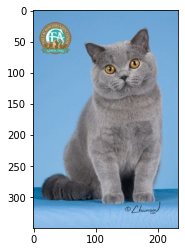

In [11]:
im = plt.imread("images/Cats_Test0.png")
plt.imshow(im)
plt.show()

In [12]:
for metadata_path, image_path in tqdm(zip(metadata_paths, images_paths)):
    if os.stat(image_path).st_size < 100000:
        image = cv2.imread(image_path)
        
        truth_rectangles, truth_label, image_id = extract_ground_truth(metadata_path)
        # print(truth_label)
        if truth_label.size > 0:
            predicted_rectangles = region_proposals(image)
            images_to_file(image, truth_rectangles, truth_label, predicted_rectangles, image_id, path="./training")

3686it [01:05, 56.13it/s]


### Removing the .ipynb_checkpoints as it was being imported and treated as an output class by mistake

In [ ]:
!rmdir /content/training/.ipynb_checkpoints

In [14]:
data_train = keras.utils.image_dataset_from_directory("./training", image_size=(227,227))

Found 7031 files belonging to 2 classes.


In [15]:
data_train.class_names

['cat', 'no_category']

Architecture of the model

In [20]:
class_weight = {0: 5, 1: 1}

input_l = keras.layers.Input(shape=(227, 227, 3))
input_layer = keras.layers.Rescaling(1./255)(input_l)
input_layer = keras.layers.ZeroPadding2D((16,16))(input_layer)
input_layer = keras.layers.RandomCrop(227,227)(input_layer)
input_layer = keras.layers.RandomFlip("horizontal")(input_layer)

headModel = keras.applications.MobileNetV2(weights="imagenet", include_top=False,input_tensor=input_layer)

for layer in headModel.layers:
    layer.trainable = False
    
headModel = headModel.output

baseModel = keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
baseModel = keras.layers.Flatten(name="flatten")(baseModel)
baseModel = keras.layers.Dense(128, activation="relu")(baseModel)
baseModel = keras.layers.Dropout(0.3)(baseModel)
output = keras.layers.Dense(4, activation="softmax")(baseModel)


model = keras.models.Model(inputs=input_l, outputs=output)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 227, 227, 3)  0           ['input_2[0][0]']                
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 259, 259, 3)  0          ['rescaling_1[0][0]']            
 D)                                                                                               
                                                                                            

# Compiling the model and training it

In [22]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

history = model.fit(data_train, epochs=5, batch_size=64)
#, class_weight=class_weight

Epoch 1/5
220/220 [==============================] - 23s 88ms/step - loss: 0.0932 - accuracy: 0.9669
Epoch 2/5
220/220 [==============================] - 19s 84ms/step - loss: 0.0299 - accuracy: 0.9900
Epoch 3/5
220/220 [==============================] - 20s 90ms/step - loss: 0.0257 - accuracy: 0.9922
Epoch 4/5
220/220 [==============================] - 19s 85ms/step - loss: 0.0240 - accuracy: 0.9913
Epoch 5/5
220/220 [==============================] - 19s 88ms/step - loss: 0.0202 - accuracy: 0.9933


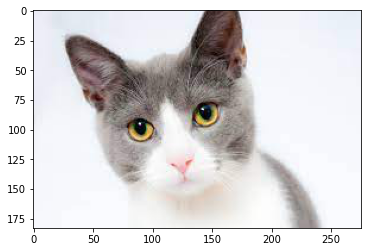

In [23]:
img = "cat.jpg"
prediction = plt.imread(img)
plt.imshow(prediction)


### For predicting an image from internet

In [24]:
def images_to_file_prediction(image, predicted_rectangles, path="."):
    """Crops boxes and writes images to files."""

    if not os.path.exists(f"{path}/"):
        os.makedirs(f"{path}/")
 
    i_id = 0
    
    for predicted_rectangle in predicted_rectangles:
        file_name = f"{path}/{i_id}.jpg"
        cropped_image = image[predicted_rectangle[2]:predicted_rectangle[3], predicted_rectangle[0]:predicted_rectangle[1]]
        img = Image.fromarray(cropped_image, 'RGB')
        img2 = img.resize((227,227), Image.ANTIALIAS)
        img2.save(file_name)
        i_id +=1

In [25]:
predicton_rectangles = region_proposals(prediction)
images_to_file_prediction(prediction, predicton_rectangles, path="./prediction/pred")
prediction_data = keras.utils.image_dataset_from_directory("./prediction", image_size=(227,227), shuffle=False)

# Model prediction
prediction_output = model.predict(prediction_data, batch_size=1)

Found 387 files belonging to 1 classes.
13/13 [==============================] - 2s 77ms/step


In [26]:
def _restructure_rectangles_xy(old_rects):
    """Converts rectangles from (x, y, w, h) to (x1, y1, x2, y2)""" 
    x1 = old_rects[:,0]
    x2 = old_rects[:,1]
    y1 = old_rects[:,2]
    y2 = old_rects[:,3]

    rects_new = old_rects.copy()
    rects_new[:,1] = x1
    rects_new[:,0] = y1
    rects_new[:,3] = x2
    rects_new[:,2] = y2
    return rects_new

new_pred_rects = _restructure_rectangles_xy(predicton_rectangles)


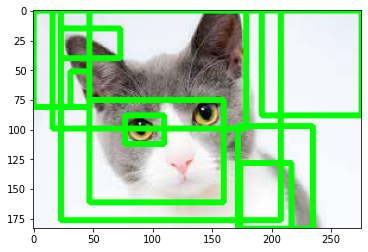

In [27]:
predictions = tf.image.non_max_suppression(new_pred_rects, prediction_output[:,0], max_output_size=10, iou_threshold=0.9)
image = plt.imread(img)

for ind_rect in predictions.numpy():    
    rectangle_coordinates = predicton_rectangles[ind_rect].astype(int)
    rectangled_image = cv2.rectangle(image, (rectangle_coordinates[0], rectangle_coordinates[2]), (rectangle_coordinates[1], rectangle_coordinates[3]), (0, 255, 0), 3)
    plt.imshow(rectangled_image)

plt.show()

### Result

This is the final output, we see there are a lot of bounding boxes. Some of them are appropriately marked while some others might be mis-matched. This might be overcome with if we train it for more epochs with a more powerful GPU/TPU
